In [1]:
import pandas as pd
import yfinance as yf
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
from full_fred.fred import Fred
import os
from dotenv import load_dotenv
from scipy import stats

# Question 1
### 1a

In [2]:
# GLOBAL CONSTS
START_DATE = '2023-01-01'         # Start date for evaluation window
END_DATE = '2023-12-31'           # End date for evaluation window
SPTL_TICKER = 'SPTL'              # SPDR Portfolio Long Term Treasury ETF
EFFR_TICKER = 'EFFR'              # Effective Fed Funds Rate
FRED_API_KEY = 'FRED_API_KEY'     # Personal Fred API key location in os environ
TRADING_DAYS = 252                # Number of trading days per year

In [3]:
# Get index data from yfinance
yf_df = yf.Ticker(SPTL_TICKER).history(start=START_DATE, end=END_DATE).reset_index()
yf_cols = yf_df.columns
yf_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2023-01-03 00:00:00-05:00,27.511990,27.558261,27.188101,27.326912,3557300,0.0,0.0,0.0
1,2023-01-04 00:00:00-05:00,27.789604,27.826619,27.539747,27.669302,4448800,0.0,0.0,0.0
2,2023-01-05 00:00:00-05:00,27.447207,27.780350,27.410192,27.780350,2795600,0.0,0.0,0.0
3,2023-01-06 00:00:00-05:00,27.641536,28.289312,27.623028,28.261551,4309600,0.0,0.0,0.0
4,2023-01-09 00:00:00-05:00,28.076475,28.455887,28.039459,28.400364,2540300,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
245,2023-12-22 00:00:00-05:00,27.836188,27.845750,27.549314,27.635376,3040400,0.0,0.0,0.0
246,2023-12-26 00:00:00-05:00,27.625815,27.731003,27.625815,27.683191,3582900,0.0,0.0,0.0
247,2023-12-27 00:00:00-05:00,27.960500,28.161311,27.893563,28.151749,2680700,0.0,0.0,0.0
248,2023-12-28 00:00:00-05:00,28.046561,28.170872,27.903126,27.970062,3364900,0.0,0.0,0.0


In [4]:
# Manipulate yfinance data
YF_DATE = 'Date'
DATE_STRING = 'date_string'
yf_df[DATE_STRING] = yf_df[YF_DATE].dt.strftime('%Y-%m-%d')

In [5]:
# Get Fred data for EFFR
fred = Fred()
load_dotenv()
fred.env_api_key_found()
fred_df = fred.get_series_df(EFFR_TICKER, observation_start=START_DATE, observation_end=END_DATE)
fred_df

,realtime_start,realtime_end,date,value
0,2025-03-25,2025-03-25,2023-01-02,.
1,2025-03-25,2025-03-25,2023-01-03,4.33
2,2025-03-25,2025-03-25,2023-01-04,4.33
3,2025-03-25,2025-03-25,2023-01-05,4.33
4,2025-03-25,2025-03-25,2023-01-06,4.33
...,...,...,...,...
255,2025-03-25,2025-03-25,2023-12-25,.
256,2025-03-25,2025-03-25,2023-12-26,5.33
257,2025-03-25,2025-03-25,2023-12-27,5.33
258,2025-03-25,2025-03-25,2023-12-28,5.33


In [6]:
# Clean and manipulate Fred data
fred_cols = fred_df.columns
VALUE = 'value'                                                         # To avoid magic strings, this is the key for the VALUE column
FRED_DATE = 'date'
fred_df.loc[fred_df[VALUE] == '.', VALUE] = fred_df[VALUE].shift(-1)    # Replace all values that are '.' with the neighouring rows VALUE
fred_df = fred_df.astype({'value': 'float32'})                          # Adjust datatype of column
DAILY_RISK_FREE = 'daily_risk_free'                                     # Avoid magic string for column name
fred_df[DAILY_RISK_FREE] = fred_df[VALUE] / TRADING_DAYS /100           # Adding in day adjusted risk free
fred_df

,realtime_start,realtime_end,date,value,daily_risk_free
0,2025-03-25,2025-03-25,2023-01-02,4.33,0.000172
1,2025-03-25,2025-03-25,2023-01-03,4.33,0.000172
2,2025-03-25,2025-03-25,2023-01-04,4.33,0.000172
3,2025-03-25,2025-03-25,2023-01-05,4.33,0.000172
4,2025-03-25,2025-03-25,2023-01-06,4.33,0.000172
...,...,...,...,...,...
255,2025-03-25,2025-03-25,2023-12-25,5.33,0.000212
256,2025-03-25,2025-03-25,2023-12-26,5.33,0.000212
257,2025-03-25,2025-03-25,2023-12-27,5.33,0.000212
258,2025-03-25,2025-03-25,2023-12-28,5.33,0.000212


In [7]:
# Merge yf and Fred to have a combined dateframe, joined on date
merged_df = pd.merge(
    left=yf_df,
    right=fred_df,
    left_on=DATE_STRING,
    right_on=FRED_DATE,
    how='left'
)[['date', YF_DATE, DAILY_RISK_FREE, VALUE]]
merged_df

,date,Date,daily_risk_free,value
0,2023-01-03,2023-01-03 00:00:00-05:00,0.000172,4.33
1,2023-01-04,2023-01-04 00:00:00-05:00,0.000172,4.33
2,2023-01-05,2023-01-05 00:00:00-05:00,0.000172,4.33
3,2023-01-06,2023-01-06 00:00:00-05:00,0.000172,4.33
4,2023-01-09,2023-01-09 00:00:00-05:00,0.000172,4.33
...,...,...,...,...
245,2023-12-22,2023-12-22 00:00:00-05:00,0.000212,5.33
246,2023-12-26,2023-12-26 00:00:00-05:00,0.000212,5.33
247,2023-12-27,2023-12-27 00:00:00-05:00,0.000212,5.33
248,2023-12-28,2023-12-28 00:00:00-05:00,0.000212,5.33


In [8]:
# Calculate the daily excess returns
DLY_RTNS = 'daily_returns'
DLY_XS_RTNS = 'daily_excess_returns'
yf_df[DLY_RTNS] = (yf_df['Close'] - yf_df['Close'].shift(1)) / yf_df['Close']    # Check this for the index
yf_df[DLY_XS_RTNS] = yf_df[DLY_RTNS] - merged_df[DAILY_RISK_FREE]

print(yf_df[DLY_XS_RTNS].std())

0.01058194832714866


### 1b

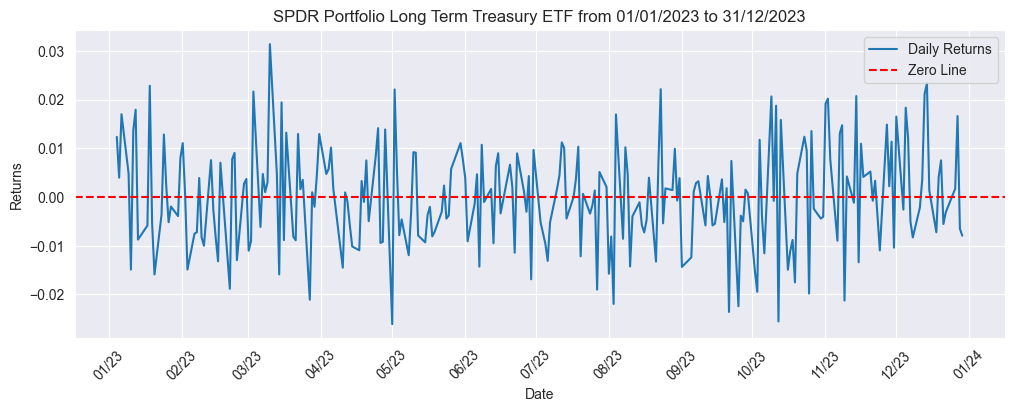

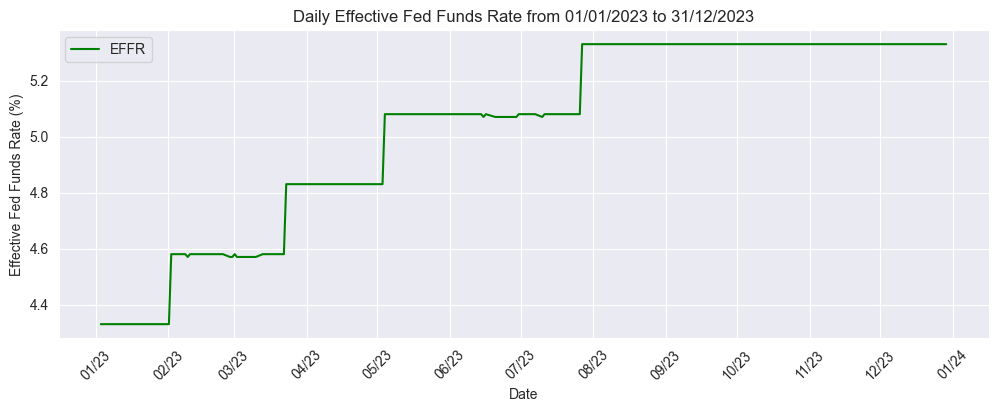

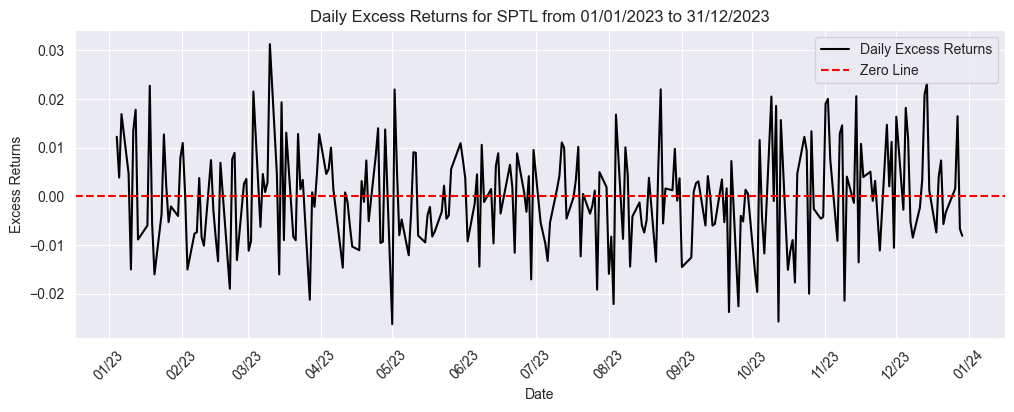

In [10]:
# Plotting data
sns.set_style("darkgrid")
start_formatted = date.fromisoformat(START_DATE).strftime('%d/%m/%Y')
end_formatted = date.fromisoformat(END_DATE).strftime('%d/%m/%Y')

# Daily returns plot
plt.figure(figsize=(12, 4))
plt.plot(yf_df[YF_DATE], yf_df[DLY_RTNS])
plt.title(f"SPDR Portfolio Long Term Treasury ETF from {start_formatted} to {end_formatted}")
plt.xlabel(f"{YF_DATE}")
plt.ylabel(f"Returns")
plt.axhline(y=0, color='r', linestyle='--')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.legend(['Daily Returns', 'Zero Line'], loc='upper right')
plt.xticks(rotation=45)
plt.savefig(f'../assets/{SPTL_TICKER}_2023_daily_returns.png', bbox_inches='tight', dpi=300)
plt.show()  

# Fed risk free rate plot
plt.figure(figsize=(12, 4))
plt.plot(merged_df[YF_DATE], merged_df[VALUE], color='green')
plt.title(f"Daily Effective Fed Funds Rate from {start_formatted} to {end_formatted}")
plt.xlabel(f"{YF_DATE}")
plt.ylabel(f"Effective Fed Funds Rate (%)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.xticks(rotation=45)
plt.legend(['EFFR'])
plt.savefig(f'../assets/2023_fed_rate.png', bbox_inches='tight', dpi=300)
plt.show()


# Excess returns plot
plt.figure(figsize=(12, 4))
plt.plot(yf_df['Date'], yf_df[DLY_XS_RTNS], color='black')
plt.title(f"Daily Excess Returns for {SPTL_TICKER} from {start_formatted} to {end_formatted}")
plt.xlabel(f"{YF_DATE}")
plt.ylabel(f"Excess Returns")
plt.axhline(y=0, color='r', linestyle='--')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.legend(['Daily Excess Returns', 'Zero Line'], loc='upper right')
plt.xticks(rotation=45)
plt.savefig(f'../assets/{SPTL_TICKER}_2023_excess_returns.png', bbox_inches='tight', dpi=300)
plt.show()


In [12]:
# Save processed data to dataframe
yf_df['daily_risk_free'] = merged_df[DAILY_RISK_FREE]
yf_df.to_csv(f'../data/{SPTL_TICKER}_2023.csv')

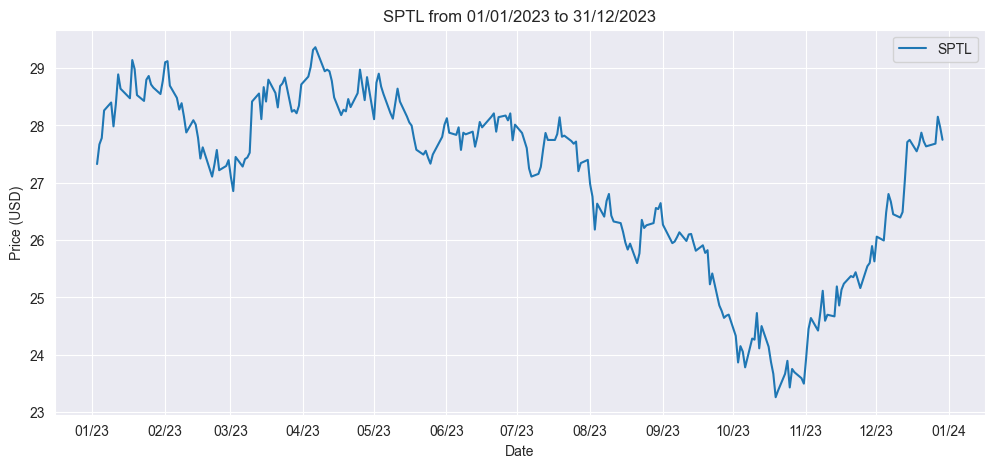

In [ ]:
# Visulize overall structure of the data
# Plot relevant numerical columns against Close price
plt.figure(12, figsize=(12,5))
plt.plot(yf_df['Date'], yf_df['Close'])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.title(f'{SPTL_TICKER} from {start_formatted} to {end_formatted}')
plt.legend([SPTL_TICKER])
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)

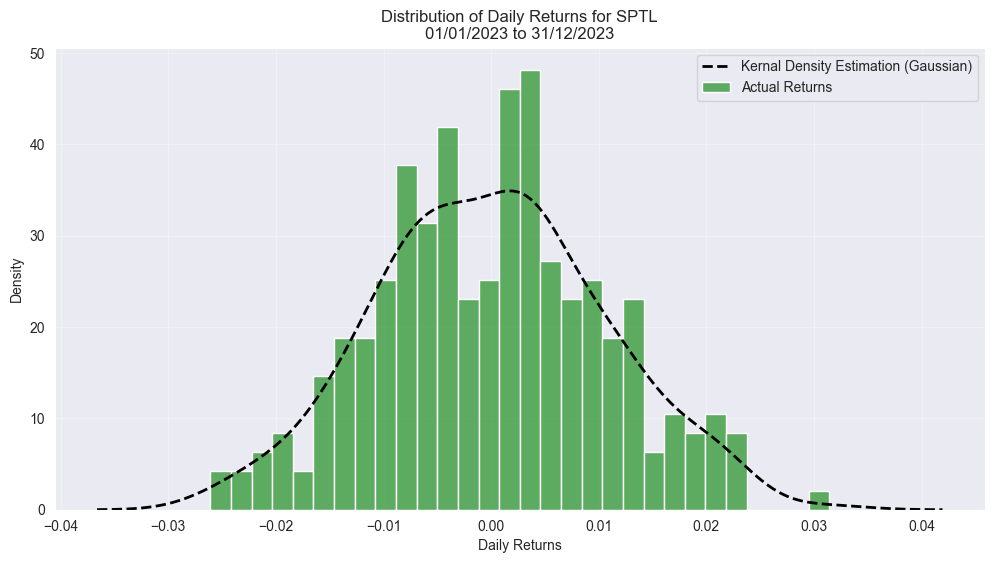

In [13]:
# Plot histogram of returns with normal distribution overlay
plt.figure(figsize=(12, 6))
sns.histplot(data=yf_df[DLY_RTNS].dropna(), bins=30, stat='density', alpha=0.6, color='green')
sns.kdeplot(data=yf_df[DLY_RTNS].dropna(), color='black', linewidth=2, linestyle='--')

plt.title(f'Distribution of Daily Returns for {SPTL_TICKER}\n{start_formatted} to {end_formatted}')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.legend(['Kernal Density Estimation (Gaussian)', 'Actual Returns'])
plt.savefig(f'../assets/{SPTL_TICKER}_2023_returns_dist.png', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
# Calculate normality statistics

# Remove NaN values from daily returns
returns = yf_df[DLY_RTNS].dropna()

# Perform Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(returns)

# Calculate skewness and kurtosis
skewness = returns.skew()
kurtosis = returns.kurtosis()

print(f"Shapiro-Wilk test:")
print(f"Statistic: {shapiro_stat:.6f}")
print(f"P-value: {shapiro_p:.6f}")
print(f"\nMean Returns: {returns.mean():.6f}")
print(f"Variance: {returns.var():.6f}")
print(f"\nSkewness: {skewness:.6f}")
print(f"Kurtosis: {kurtosis:.6f}")

# Test if significantly different from normal distribution
alpha = 0.05
is_normal = shapiro_p > alpha

print(f"\nIs the distribution normal (α={alpha})? {is_normal}")

Shapiro-Wilk test:
Statistic: 0.995905
P-value: 0.758065

Mean Returns: 0.000006
Variance: 0.000112

Skewness: 0.096048
Kurtosis: -0.207229

Is the distribution normal (α=0.05)? True
